<a href="https://colab.research.google.com/github/sasha-kap/Events-Analytics/blob/master/GDELT_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [34]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth',500)

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
plt.style.use('seaborn-white') # use plt.style.available to see list of available styles

import pickle

from google.cloud import bigquery

In [2]:
import sys
sys.version

'3.6.9 (default, Jul 17 2020, 12:50:27) \n[GCC 8.4.0]'

In [3]:
print("matplotlib version:", mpl.__version__)
print("pandas version:", pd.__version__)

matplotlib version: 3.2.2
pandas version: 1.0.5


In [4]:
project_id = 'spark-project-254623'
bucket_name = 'spark-projects'

###Provide credentials to the runtime

In [5]:
# authenticates Colab to the Google Cloud account
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


### BigQuery dry run

Dry run query to check query size across different date ranges:

In [6]:
client = bigquery.Client(project=project_id)

job_config = bigquery.QueryJobConfig()
job_config.dry_run = True
job_config.use_query_cache = False

sql =   '''
        SELECT *
        FROM `gdelt-bq.gdeltv2.events_partitioned`
        WHERE
            _PARTITIONDATE BETWEEN '2018-04-04' AND '2018-04-04'
        '''

query_job = client.query(
    sql,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
    job_config=job_config,
)  # API request

# A dry run query completes immediately.
assert query_job.state == "DONE"
assert query_job.dry_run

print("This query will process {:,} bytes.".format(query_job.total_bytes_processed))

This query will process 144,510,139 bytes.


### Query Events Table

In [ ]:
client = bigquery.Client(project=project_id)

sql =   '''
        SELECT *
        FROM `gdelt-bq.gdeltv2.events_partitioned`
        WHERE
            _PARTITIONDATE BETWEEN '2019-12-01' AND '2019-12-07'
        '''

df = client.query(sql, location="US").to_dataframe()

### Save DataFrame to Pickle and then copy to existing Cloud Storage bucket

In [ ]:
df.to_pickle("./dec19_wk1_events.pkl")

In [ ]:
# upload file to GCS bucket
!gsutil cp ./dec19_wk1_events.pkl gs://{bucket_name}/dec19_wk1_events.pkl

Copying file://./dec19_wk1_events.pkl [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

-
Operation completed over 1 objects/689.8 MiB.                                    


### Copy Pickle file back to Colab instance

In [6]:
# run authentication before running this cell
!gsutil cp gs://{bucket_name}/dec19_wk1_events.pkl ./dec19_wk1_events.pkl

df = pd.read_pickle("./dec19_wk1_events.pkl")

Copying gs://spark-projects/dec19_wk1_events.pkl...
| [1 files][689.8 MiB/689.8 MiB]   61.0 MiB/s                                   
Operation completed over 1 objects/689.8 MiB.                                    


### Exploratory Analysis of Queried Events

#### Dataset Properties



In [7]:
print(df.shape)

(1496551, 61)


In [8]:
df.columns

Index(['GLOBALEVENTID', 'SQLDATE', 'MonthYear', 'Year', 'FractionDate',
       'Actor1Code', 'Actor1Name', 'Actor1CountryCode', 'Actor1KnownGroupCode',
       'Actor1EthnicCode', 'Actor1Religion1Code', 'Actor1Religion2Code',
       'Actor1Type1Code', 'Actor1Type2Code', 'Actor1Type3Code', 'Actor2Code',
       'Actor2Name', 'Actor2CountryCode', 'Actor2KnownGroupCode',
       'Actor2EthnicCode', 'Actor2Religion1Code', 'Actor2Religion2Code',
       'Actor2Type1Code', 'Actor2Type2Code', 'Actor2Type3Code', 'IsRootEvent',
       'EventCode', 'EventBaseCode', 'EventRootCode', 'QuadClass',
       'GoldsteinScale', 'NumMentions', 'NumSources', 'NumArticles', 'AvgTone',
       'Actor1Geo_Type', 'Actor1Geo_FullName', 'Actor1Geo_CountryCode',
       'Actor1Geo_ADM1Code', 'Actor1Geo_ADM2Code', 'Actor1Geo_Lat',
       'Actor1Geo_Long', 'Actor1Geo_FeatureID', 'Actor2Geo_Type',
       'Actor2Geo_FullName', 'Actor2Geo_CountryCode', 'Actor2Geo_ADM1Code',
       'Actor2Geo_ADM2Code', 'Actor2Geo_Lat', 'Act

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1496551 entries, 0 to 1496550
Data columns (total 61 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   GLOBALEVENTID          1496551 non-null  int64  
 1   SQLDATE                1496551 non-null  int64  
 2   MonthYear              1496551 non-null  int64  
 3   Year                   1496551 non-null  int64  
 4   FractionDate           1496551 non-null  float64
 5   Actor1Code             1341035 non-null  object 
 6   Actor1Name             1341038 non-null  object 
 7   Actor1CountryCode      783423 non-null   object 
 8   Actor1KnownGroupCode   23614 non-null    object 
 9   Actor1EthnicCode       8737 non-null     object 
 10  Actor1Religion1Code    18476 non-null    object 
 11  Actor1Religion2Code    5172 non-null     object 
 12  Actor1Type1Code        686425 non-null   object 
 13  Actor1Type2Code        39625 non-null    object 
 14  Actor1Type3Code   

#### Actor and Event Codes

Let's import the Event Descriptions lookup table.

In [37]:
event_lt = pd.read_csv("https://gdeltproject.org/data/lookups/CAMEO.eventcodes.txt", sep='\t', dtype={'CAMEOEVENTCODE':str})

In [40]:
event_lt.set_index('CAMEOEVENTCODE',inplace=True)

In [47]:
event_lt.head()

,EVENTDESCRIPTION
CAMEOEVENTCODE,
01,MAKE PUBLIC STATEMENT
010,"Make statement, not specified below"
011,Decline comment
012,Make pessimistic comment
013,Make optimistic comment


First, we see that Actor1Code is not always recorded.  Let's check if there is any correlation between EventCode and whether Actor1Code is present or null.

In [ ]:
# tabulate number of unique EventCode's in cases where Actor1Code is null
df[df.Actor1Code.isnull()]['EventCode'].unique().shape

(200,)

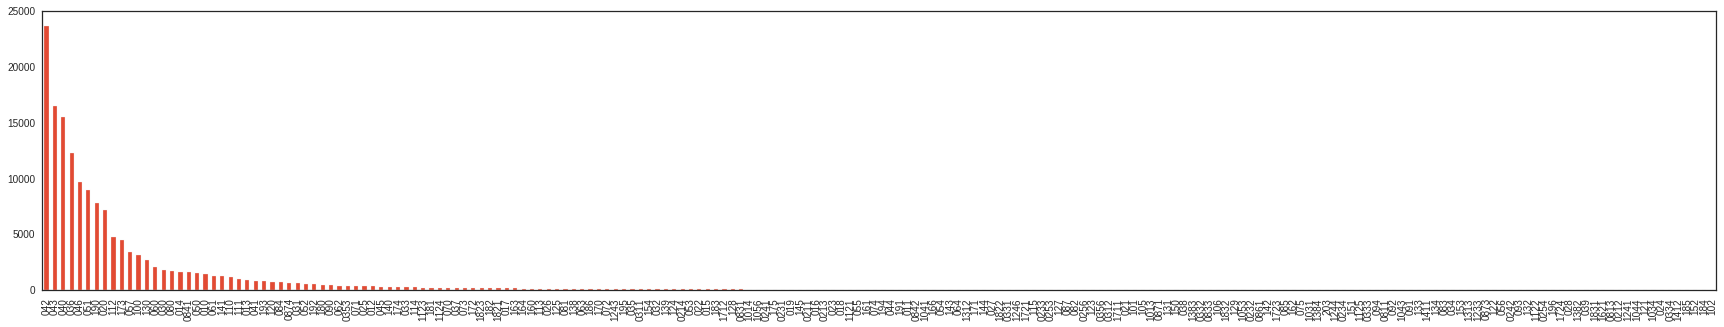

In [ ]:
# plot frequencies of EventCode values for events when Actor1Code is null
plt.figure(figsize=(30,5))
df[df.Actor1Code.isnull()]['EventCode'].value_counts().plot(kind="bar")
plt.show()

In [54]:
# display top 10 most frequent event codes when Actor1Code is null
event_code_cts = df[df.Actor1Code.isnull()]['EventCode'].value_counts().nlargest(10)
event_lt.merge(event_code_cts, left_index=True, right_index=True, how='right').rename({'EventCode':'N_EVENTS'},axis=1)

,EVENTDESCRIPTION,N_EVENTS
042,Make a visit,23679
043,Host a visit,16537
040,"Consult, not specified below",15494
036,Express intent to meet or negotiate,12304
046,Engage in negotiation,9746
051,Praise or endorse,8944
190,"Use conventional military force, not specified below",7856
020,"Appeal, not specified below",7204
112,"Accuse, not specified below",4799
173,"Arrest, detain, or charge with legal action",4533


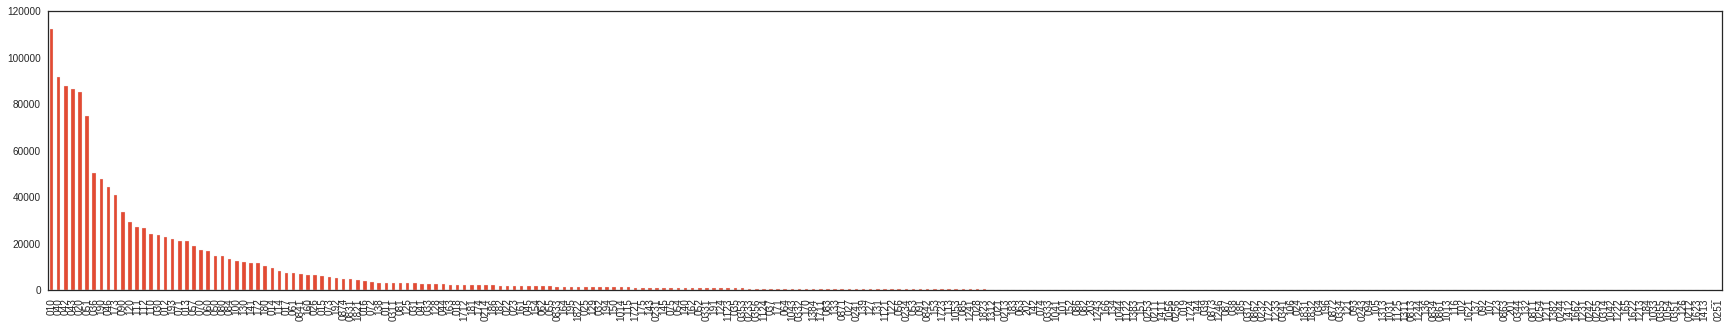

In [ ]:
# plot frequencies of EventCode values for events when Actor1Code is NOT null
plt.figure(figsize=(30,5))
df[df.Actor1Code.notnull()]['EventCode'].value_counts().plot(kind="bar")
plt.show()

In [55]:
# display top 10 most frequent event codes when Actor1Code is NOT null
event_code_cts = df[df.Actor1Code.notnull()]['EventCode'].value_counts().nlargest(10)
event_lt.merge(event_code_cts, left_index=True, right_index=True, how='right').rename({'EventCode':'N_EVENTS'},axis=1)

,EVENTDESCRIPTION,N_EVENTS
010,"Make statement, not specified below",112387
040,"Consult, not specified below",91936
042,Make a visit,87971
043,Host a visit,86519
020,"Appeal, not specified below",85240
051,Praise or endorse,75117
036,Express intent to meet or negotiate,50253
190,"Use conventional military force, not specified below",47812
046,Engage in negotiation,44446
173,"Arrest, detain, or charge with legal action",40946


In [ ]:
#get counts of '010' code in the EventCode column, grouped by whether Actor1Code is null or not null
print("count of 010 code when Actor1Code is null:", int(df[(df.Actor1Code.isnull()) & (df.EventCode == '010')]['EventCode'].value_counts().values))
print("count of 010 code when Actor1Code is not null:", int(df[(df.Actor1Code.notnull()) & (df.EventCode == '010')]['EventCode'].value_counts().values))

count of 010 code when Actor1Code is null: 1485
count of 010 code when Actor1Code is not null: 112387


010 Code appears quite frequently when Actor1Code is NOT null, but rarely when it IS null.  Per https://www.gdeltproject.org/data/lookups/CAMEO.eventcodes.txt, 010 is "Make statement, unspecified".  So, there is this one noticeable difference, but many codes still appear in large numbers regardless of Actor1Code being present.

Let's look into Actor2Code.  Maybe it can help us better understand the relationship between EventCode and presence of one or both of the ActorCode's.

In [ ]:
# Check for overlaps between presence of Actor1Code and Actor2Code
print("Actor1Code NULL, Actor2Code NOT NULL:", df[df.Actor1Code.isnull() & df.Actor2Code.notnull()].shape[0], f"{df[df.Actor1Code.isnull() & df.Actor2Code.notnull()].shape[0] / df.shape[0] :.2%}")
print("Actor1Code NULL, Actor2Code NULL:", df[df.Actor1Code.isnull() & df.Actor2Code.isnull()].shape[0], f"{df[df.Actor1Code.isnull() & df.Actor2Code.isnull()].shape[0] / df.shape[0] :.2%}")
print("Actor1Code NOT NULL, Actor2Code NOT NULL:", df[df.Actor1Code.notnull() & df.Actor2Code.notnull()].shape[0], f"{df[df.Actor1Code.notnull() & df.Actor2Code.notnull()].shape[0] / df.shape[0] :.2%}")
print("Actor1Code NOT NULL, Actor2Code NULL:", df[df.Actor1Code.notnull() & df.Actor2Code.isnull()].shape[0], f"{df[df.Actor1Code.notnull() & df.Actor2Code.isnull()].shape[0] / df.shape[0] :.2%}")

Actor1Code NULL, Actor2Code NOT NULL: 155514 10.39%
Actor1Code NULL, Actor2Code NULL: 2 0.00%
Actor1Code NOT NULL, Actor2Code NOT NULL: 877322 58.62%
Actor1Code NOT NULL, Actor2Code NULL: 463713 30.99%


We see that when Actor1Code is null, Actor2Code is almost always not null.  So at least we can get one actor in those cases.
When Actor1Code is not null, Actor2Code is present only about 60% of the time.
It will need to be determined what it means for one of the ActorCode fields to be present and for the second to be null.

Let's check if there is a noticeable difference in EventCode values when Actor2Code is null versus not null, with Actor1Code present.

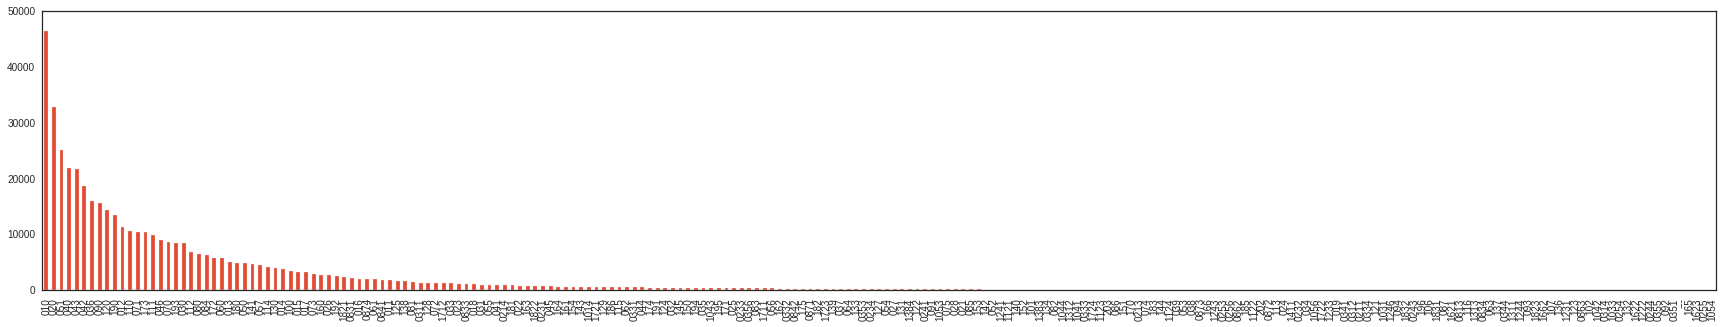

In [ ]:
# plot frequencies of EventCode values for events when Actor1Code is NOT null and Actor2Code IS null
plt.figure(figsize=(30,5))
df[df.Actor1Code.notnull() & df.Actor2Code.isnull()]['EventCode'].value_counts().plot(kind="bar")
plt.show()

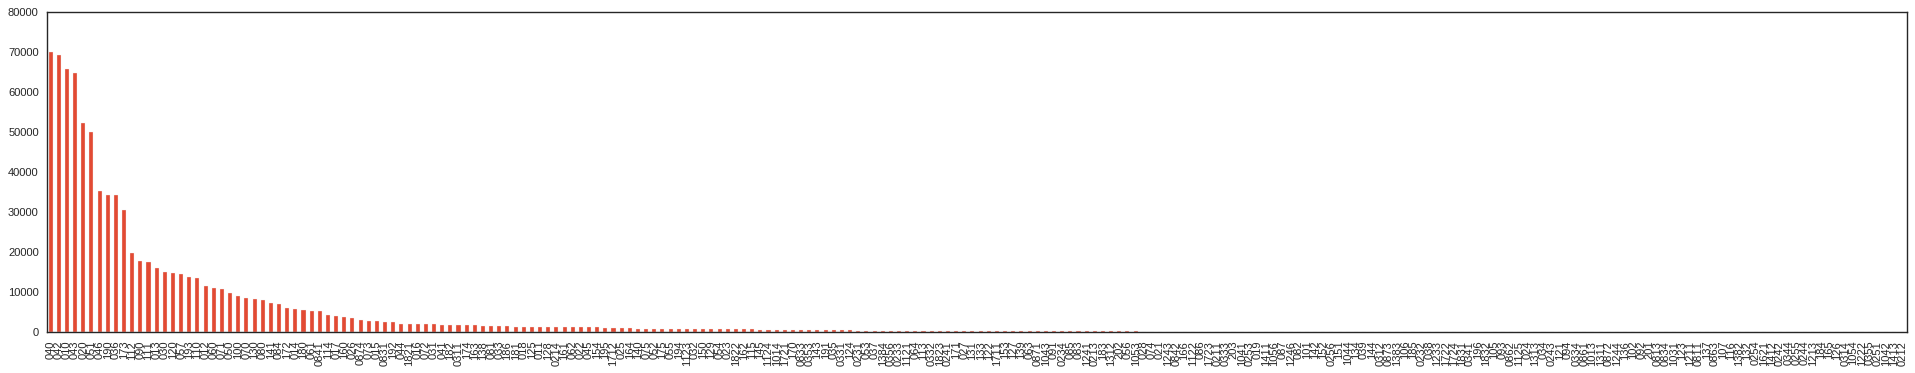

In [ ]:
# plot frequencies of EventCode values for events when Actor1Code is NOT null and Actor2Code is NOT null
plt.figure(figsize=(30,5))
df[df.Actor1Code.notnull() & df.Actor2Code.notnull()]['EventCode'].value_counts().plot(kind="bar")
plt.show()

In [83]:
# let's plot the counts side by side for each EventCode (just the top 10 for case when Actor2Code is present and when it is null)
# first, subset the dataframe to rows where Actor1Code is not null
temp_df = df[df.Actor1Code.notnull()][['EventCode','Actor2Code']]

# create boolean column indicating whether Actor2Code is null or not null
temp_df['Actor2CodeIsNull'] = temp_df['Actor2Code'].apply(lambda x: x is None)

# create column that includes counts of each EventCode value, grouped by Actor2CodeIsNull, in the corresponding rows
temp_df['Count'] = temp_df.groupby(['EventCode','Actor2CodeIsNull']).transform(len)

# create column ranking count values within each Actor2CodeIsNull category (largest counts receive smallest(top) rank values)
temp_df['Rank'] = temp_df.groupby('Actor2CodeIsNull')['Count'].rank(ascending=False, method='min')

# subset dataframe to rows where Rank value is at or below the 10th smallest Rank value in Actor2CodeIsNull group
cond_null = (temp_df.Actor2CodeIsNull == 1) & (temp_df.Rank <= np.sort(temp_df[temp_df.Actor2CodeIsNull == 1]['Rank'].unique())[9])
cond_notnull = (temp_df.Actor2CodeIsNull == 0) & (temp_df.Rank <= np.sort(temp_df[temp_df.Actor2CodeIsNull == 0]['Rank'].unique())[9])

# verify the results
vc = pd.DataFrame(temp_df[cond_null | cond_notnull].groupby('Actor2CodeIsNull')['EventCode'].value_counts())
vc.rename(columns={'EventCode':"N_EVENTS"}, inplace=True)

In [88]:
# merge with event code descriptions lookup table
event_lt.index.names = ['EventCode']
event_lt.join(vc,how='inner')

EVENTDESCRIPTION  N_EVENTS
Actor2CodeIsNull EventCode                                                                
False            040                                Consult, not specified below     70096
                 042                                                Make a visit     69304
                 010                         Make statement, not specified below     65855
                 043                                                Host a visit     64852
                 020                                 Appeal, not specified below     52323
                 051                                           Praise or endorse     49994
                 046                                       Engage in negotiation     35405
                 190        Use conventional military force, not specified below     34311
                 036                         Express intent to meet or negotiate     34229
                 173                Arrest, detain, or charge with legal action      30584
True             010                         Make statement, not specified below     46532
                 020                                 Appeal, not specified below     32917
                 051                                           Praise or endorse     25123
                 040                                Consult, not specified below     21840
                 043                                                Host a visit     21667
                 042                                                Make a visit     18667
                 036                         Express intent to meet or negotiate     16024
                 090                            Investigate, not specified below     15638
                 120                                 Reject, not specified below     14419
                 190        Use conventional military force, not specified below     13501

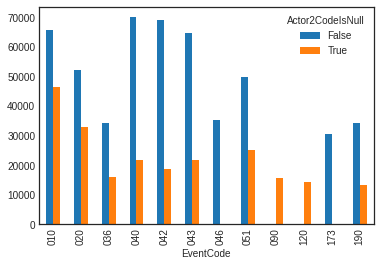

In [89]:
# plot frequencies of EventCode values for events when Actor1Code is NOT null and Actor2Code is NOT null
temp_df[cond_null | cond_notnull].groupby('EventCode')['Actor2CodeIsNull'] \
    .value_counts().unstack().plot(kind="bar")
plt.show()

There is a bit of a difference in distributions of EventCode values in those situations, but not significant enough or easily interpretable to understand how it relates to the presence of Actor2Code or lack thereof.

In [ ]:
#check number of unique Actor1Code values
df[df.Actor1Code.notnull()].Actor1Code.value_counts().shape[0]

5158

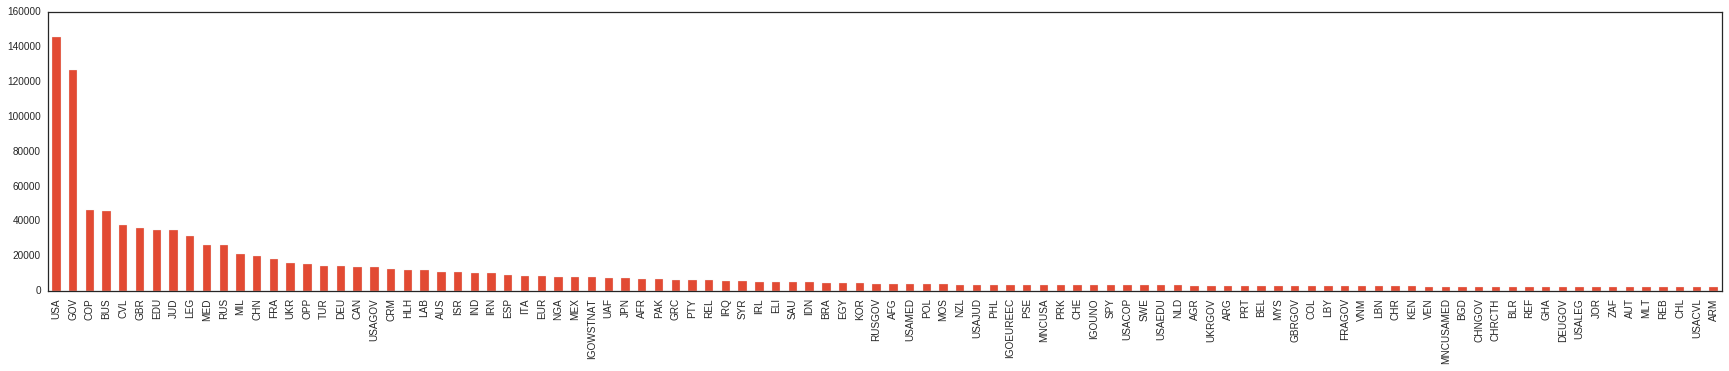

In [ ]:
# plot frequencies of 100 most frequent Actor1Code values
plt.figure(figsize=(30,5))
df[df.Actor1Code.notnull()]['Actor1Code'].value_counts().nlargest(100).plot(kind="bar")
plt.show()

In [ ]:
# Check the most frequent combinations of Actor1Code and Actor2Code
df.groupby([df.Actor1Code, df.Actor2Code]).size().nlargest(40)

Actor1Code  Actor2Code
USA         GOV           7849
GOV         USA           7732
USA         EDU           5721
            COP           5018
COP         USA           4694
USA         BUS           4569
EDU         USA           4468
USA         CVL           4466
JUD         USA           4114
USA         JUD           3757
LEG         GOV           3736
BUS         USA           3463
CVL         USA           3416
GOV         BUS           3284
            LEG           3283
USA         LEG           3183
USAGOV      USA           3150
USA         USAGOV        3054
GOV         CVL           2771
USA         MIL           2635
LEG         USA           2527
USA         MED           2436
BUS         GOV           2422
GOV         GBR           2414
RUS         UKR           2268
UKR         RUS           2234
GBR         GOV           2188
USA         UKR           2050
MIL         USA           2041
MED         USA           2028
USA         GBR           1964
GOV         EDU 

Many domestic group codes above (like LEG (Legislature) or MED (Media)) do not include a country code, so it is not clear which country's group is being referenced.

In [ ]:
# Check which Actor1CountryCode values exist when Actor1Code just has one of the primary or secondary role codes
df[df.Actor1Code.isin(['GOV','COP','EDU','MIL','JUD','LEG','BUS','CVL','MED'])]['Actor1CountryCode'].value_counts()

Series([], Name: Actor1CountryCode, dtype: int64)

It does not look like Actor1CountryCode can assist in identifying the country of group in the Actor1Code column.  Let's check if Actor1Name can assist.

In [ ]:
df[df.Actor1Code.isin(['GOV','COP','EDU','MIL','JUD','LEG','BUS','CVL','MED'])]['Actor1Name'].value_counts()

PRESIDENT                         29993
POLICE                            27258
GOVERNMENT                        24498
COMPANY                           12497
SCHOOL                            12002
                                  ...  
MINIST FOR ECONOMY AND FINANCE        1
SCHOOLS                               1
ATTACK HELICOPTER                     1
NON RESIDENTS                         1
AMBASSADOR FOR A                      1
Name: Actor1Name, Length: 780, dtype: int64

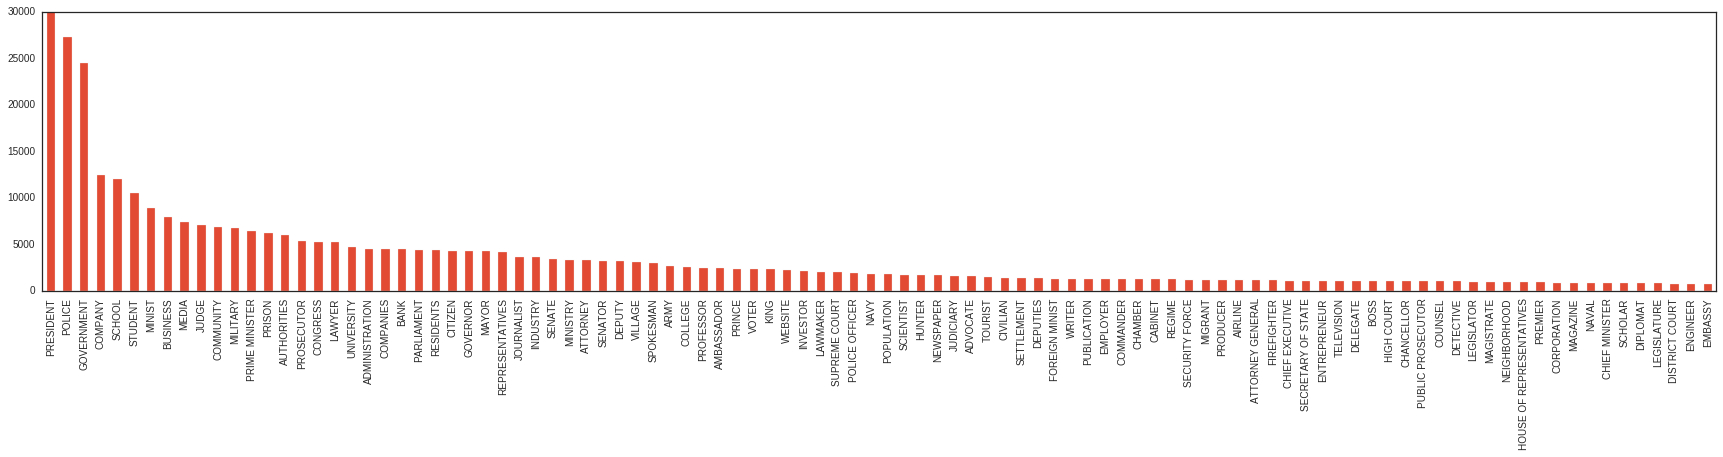

In [ ]:
# plot frequencies of 100 most frequent Actor1Name values when Actor1Code has one of the main domestic group values
plt.figure(figsize=(30,5))
df[df.Actor1Code.isin(['GOV','COP','EDU','MIL','JUD','LEG','BUS','CVL','MED'])]['Actor1Name'].value_counts().nlargest(100).plot(kind="bar")
plt.show()

Even though documentation says that Actor1Name contains the "actual name of the Actor1", Actor1Name values appear to be just more specific categories of Actor1Code, not actual names.

Let's investigate the Actor1CountryCode field a bit more.

In [ ]:
# Check what values the field generally takes.
df.Actor1CountryCode.value_counts(dropna=False)

NaN    713128
USA    192390
GBR     43375
RUS     33352
CHN     23648
        ...  
SHN        13
CAS        11
LAM         6
SMR         6
SCN         4
Name: Actor1CountryCode, Length: 217, dtype: int64

In [ ]:
# Check what Actor1Code values exist when Actor1CountryCode is USA
df[df.Actor1CountryCode == "USA"]['Actor1Code'].value_counts(dropna=False)

USA             145273
USAGOV           13571
USAMED            4133
USAJUD            3524
MNCUSA            3421
                 ...  
USAEDUREF            1
MNCUSAHLHLEG         1
USAGUMMIL            1
USAGUMCVL            1
MNCUSAAGRBUS         1
Name: Actor1Code, Length: 141, dtype: int64

#### Geography Codes

In [ ]:
# Check values of Actor1Geo_Type
df.Actor1Geo_Type.value_counts(dropna=False)

4    577831
1    405877
0    198945
3    165238
2    124355
5     24305
Name: Actor1Geo_Type, dtype: int64

It is not clear what the 0 value represents (documentation only identifies 1 through 5). To try and understand what the 0 value represents, let's check the Actor1Geo_Fullname column for those values.  We saw earlier that Actor1Geo_FullName is null roughly the same number of times as there are 0 values in Actor1Geo_Type.

In [ ]:
df[df.Actor1Geo_Type == 0]['Actor1Geo_FullName'].value_counts()

Series([], Name: Actor1Geo_FullName, dtype: int64)

In [ ]:
df[df.Actor1Geo_FullName.isnull()]['Actor1Geo_Type'].value_counts()

0    198945
1       895
Name: Actor1Geo_Type, dtype: int64

So, in all cases when Geo_Type is 0, Geo_FullName is null.  There is a small number of cases when Geo_FullName is null, but Geo_Type takes on the value 1 (Country).

In [ ]:
df[df.Actor1Geo_FullName.isnull() & df.Actor1Geo_Type == 1]['Actor1Geo_CountryCode'].value_counts(dropna=False)

RB    830
YI     65
Name: Actor1Geo_CountryCode, dtype: int64

So, at least country name is available in the Geo_CountryCode field when Geo_FullName is null, except that these two codes (RB and YI are not found in the FIPS10-4 country code list (https://en.wikipedia.org/wiki/List_of_FIPS_country_codes, https://www.gdeltproject.org/data/lookups/FIPS.country.txt)

In [ ]:
# Check what ActionGeo_CountryCode values exist for those RB and YI Actor1 values
df[df.Actor1Geo_FullName.isnull() & (df.Actor1Geo_Type == 1)].groupby(['Actor1Geo_CountryCode','ActionGeo_CountryCode']).size()

Actor1Geo_CountryCode  ActionGeo_CountryCode
RB                     AL                        11
                       AU                         5
                       BK                         7
                       BO                         1
                       BU                         6
                       GM                         3
                       GR                         2
                       HR                         4
                       HU                         3
                       KV                        21
                       MJ                         3
                       MK                         4
                       MT                         1
                       PA                         1
                       RB                       682
                       RI                        33
                       RS                        25
                       SA                         1
                   

In [ ]:
# Download country code FIPS crosswalk file to check against
url = 'https://www.gdeltproject.org/data/lookups/FIPS.country.txt'

country_fips_df = pd.read_csv(url, header=None, delimiter='\t', names=['code','country'])

country_fips_df.head()

,code,country
0,AF,Afghanistan
1,AX,Akrotiri Sovereign Base Area
2,AL,Albania
3,AG,Algeria
4,AQ,American Samoa


In [ ]:
# Check whether FIPS10-4 country codes found in the Events table can all be mapped to the crosswalk file
event_countries = df.Actor1Geo_CountryCode.values.tolist()
xwalk_countries = country_fips_df.code.values.tolist()

list(set(event_countries) - set(xwalk_countries))

[None, 'YI', 'RB', 'OC']

So, YI, RB and OC are country codes found in the Events table but not in the code-to-country_name crosswalk.  (The same results as above are observed for Actor2Geo_CountryCode and ActionGeo_CountryCode values.  And these three values are also not found in the GENC country code list that superseded FIPS codes.)

In [ ]:
# Check
df[df.Actor1Code.isin(['GOV','COP','EDU','MIL','JUD','LEG','BUS','CVL','MED'])]['Actor1Geo_Type'].value_counts()

4    169772
1    112544
3     52950
2     42601
0     18963
5      8703
Name: Actor1Geo_Type, dtype: int64

In [ ]:
df[df.Actor1Code.isin(['GOV','COP','EDU','MIL','JUD','LEG','BUS','CVL','MED'])]['Actor1Geo_CountryCode'].value_counts()

US    103192
IN     22160
UK     17888
RS     14148
UP     10965
       ...  
TL         1
FK         1
PC         1
IM         1
NF         1
Name: Actor1Geo_CountryCode, Length: 241, dtype: int64